# Tarea 3

Milne equation for flux in a gray atmosphere.

## Python imports and setup

Mathematical functions from numpy and scipy

In [16]:
import numpy as np
from scipy.special import expn
from scipy.integrate import romberg, quad

Units and constants from astropy

In [14]:
import astropy.units as u
from astropy.constants import c, k_B, h, sigma_sb

Plotting with matplotlib and seaborn

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='notebook', 
        style='whitegrid', 
        palette='dark',
        font_scale=1.5,
        color_codes=True)


/Users/will/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Some definitions:

* Dimensionless frequency: $\alpha = h\nu\, /\, kT_\mathrm{eff}$
* Eddington flux: $H_{\alpha} = H_{\nu}\, d\nu/d\alpha$
* Reciprocal dimensionless temperature: $p(\tau) = T_\mathrm{eff} \,/\, T(\tau)$
* Planck function: $B(\tau) = (\sigma/\pi) T^4$

## Results from LTE grey atmosphere in Edd approx

* Bolometric flux (constant with depth): $H = \sigma T_\mathrm{eff}^4 \,/\, 4 \pi$
* Frequency-integrated Source function, Planck function, and mean intensity: $S = B = J = 3 H (\tau + \frac{2}{3})$
* $\Rightarrow$ $B\big[\tau = \frac23\big] = B(T_\mathrm{eff}) = 4 H$

### Dimensionless reciprocal temperature

From the above 
$$ \textstyle
(\sigma/\pi) T^4 = 3 (\sigma/4\pi) T_\mathrm{eff}^4 (\tau + \frac{2}{3}),
$$ 
which implies that
$$
p(\tau)^4 = \frac{4}{3\tau + 2}
$$
  

In [2]:
def p(tau):
    return (4.0 / (3.0*tau + 2.0))**0.25

## Planck function

Frequency-resolved version: 
$$
B_\alpha = 
\frac{d\nu}{d\alpha} B_\nu =
\frac{k T_\mathrm{eff}}{h}
\frac{2 h }{c^2} 
\left(\frac{k T_\mathrm{eff}}{h}\right)^3
\frac{\alpha^3}{e^{\alpha p(\tau)} - 1}
= \frac{2 k^4 T_\mathrm{eff}^4}{h^3 c^2}
\frac{\alpha^3}{e^{\alpha p(\tau)} - 1}
$$

Normalization with respect to $B(T_\mathrm{eff})$:
$$
\frac{B_\alpha}{B(T_\mathrm{eff})} = \frac{C\, \alpha^3}{e^{\alpha p(\tau)} - 1}
$$
where the constant is
$$
C = \frac{2\pi k^{4}}{h^{3} c^{2} \sigma}.  
$$


In [114]:
bigC = 2*np.pi*k_B**4 / (h**3 * c**2 * sigma_sb)
bigC = bigC.value
print('C =', bigC)

C = 0.15398972357101687


Note that we use the `.value` method so that `bigC` is a float and not a `astropy.unit.Quantity`.  Otherwise, the integration functions become very slow.

In [115]:
def planck(alpha, tau):
    return bigC * alpha**3 / (np.exp(alpha*p(tau)) - 1.0)

### Plot the Planck function

In [119]:
alpha_pts = np.linspace(0.0, 12.0, 200)
taus = [0.0, 1.0, 2.0, 4.0, 8.0]
alphas = [1.0, 3.0, 9.0]
tau_pts = np.linspace(0.0, 20.0, 200)
tau_label = r'Optical depth: $\tau$'
alpha_label = r'Frequency: $\alpha = h \nu / k T_\mathrm{eff}$'
planck_label = r'Planck function: $B_\alpha[T(\tau)] / B[T_\mathrm{eff}]$'

#### Plot $B$ versus frequency for different depths

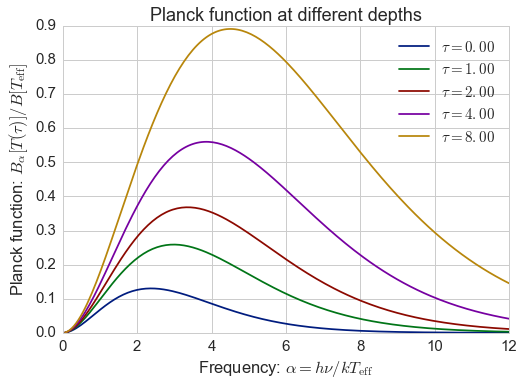

In [88]:
fig, ax = plt.subplots(1, 1)
for tau in taus:
    B = planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, label=r'$\tau = {:.2f}$'.format(tau))
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(planck_label)
ax.set_title('Planck function at different depths')
None

Note that magnitude and peak frequency of $B_\alpha$ both increase with $\tau$.  

In order to normalize the curves to the same area, we could plot $B_\alpha / B(T)$ instead of $B_\alpha / B(T_\mathrm{eff})$, so we multiply by $p(\tau)^4$:

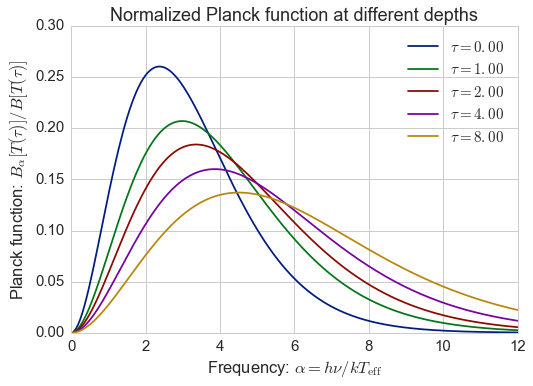

In [89]:
fig, ax = plt.subplots(1, 1)
for tau in taus:
    B = p(tau)**4 * planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, label=r'$\tau = {:.2f}$'.format(tau))
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(planck_label.replace(r'T_\mathrm{eff}', r'T(\tau)'))
ax.set_title('Normalized Planck function at different depths')
None

#### Plot $B$ versus depths for different frequencies.

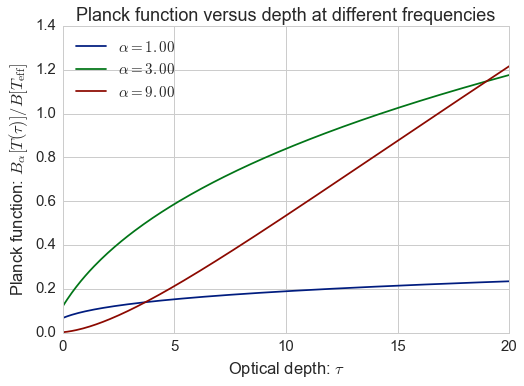

In [91]:
fig, ax = plt.subplots(1, 1)
for alpha in alphas:
    B = planck(alpha, tau_pts)
    ax.plot(tau_pts, B, label=r'$\alpha = {:.2f}$'.format(alpha))
ax.legend(loc='upper left')
ax.set_xlabel(tau_label)
ax.set_ylabel(planck_label)
ax.set_title('Planck function versus depth at different frequencies')
None

* On the Rayleigh-Jeans side ($\alpha = 1$), the Planck function grows only slowly with depth.
* Near the photospheric peak ($\alpha = 3$), the Planck function increases steeply for $\tau < 3$, but then levels off. 
* On the Wien side ($\alpha = 9$), the Planck function is low at the surface, but increases steeply at depth.

## Flux integral from Milne equation

General equation for flux is
$$
H_\nu(\tau) = \frac12 \left[
\int_{\tau}^{\infty} 
S_\nu(t)\, E_2(t - \tau) \, dt
\; -
\int_0^{\tau}
S_\nu(t)\, E_2(\tau - t) \, dt
\right]
$$
which in our case becomes
$$
H_{\alpha}(\tau) = \frac12 \left[
\int_{\tau}^{\infty} 
B_\alpha(t)\, E_2(t - \tau) \, dt
\; -
\int_0^{\tau}
B_\alpha(t)\, E_2(\tau - t) \, dt
\right]
$$

In which $B_\alpha = 4 H C \alpha^3 / (e^{\alpha p(\tau)} - 1)$ (see above).  So that
$$
\frac{H_{\alpha}(\tau)}{H} = 2 C \alpha^3
\left[ \int_{\tau}^{\infty} 
\frac{E_2(t - \tau) \, dt }{e^{\alpha p(\tau)} - 1} 
\; - 
\int_0^{\tau} 
\frac{E_2(\tau - t) \, dt }{e^{\alpha p(\tau)} - 1}
\right]
$$



### Define the integrand in the Milne equation

We write it as 
$$
2\, E_2(\vert t - \tau\vert) \, B_\alpha(t) \big/ B(T_\mathrm{eff})
$$
so that the constant $2 C$ is automatically included.

In [76]:
def milne_integrand(t, alpha, tau):
    return 2.0*expn(2, abs(t - tau))*planck(alpha, t)

### Perform the flux integrals

#### Negative contribution to flux from downward-moving photons

In [72]:
def downward(alpha, tau, integrand=milne_integrand):
    result, error = quad(integrand, 0.0, tau, args=(alpha, tau))
    return result

#### Positive contribution to flux from upward-moving photons
Even though the upper limit is $t=\infty$, the `quad` routine from `scipy.integrate`, which is a wrapper for routines from the Fortran library QUADPACK, can still cope.

In [73]:
def upward(alpha, tau, integrand=milne_integrand):
    result, error = quad(integrand, tau, np.infty, args=(alpha, tau))
    return result

#### Net flux is difference between upward and downward streams

Note that the integrations only work with scalar `alpha` and `tau`, so we need to deal with vectorization here.  For the moment, we assume that `alpha` is an array, but `tau` is scalar. 

In [77]:
def flux(alpha, tau):
    rslt = np.empty_like(alpha)
    for i, a in enumerate(alpha):
        rslt[i] = upward(a, tau) - downward(a, tau)
    return rslt

## Plot the fluxes

In [79]:
flux_label = r'Radiative flux: $H_\alpha(\tau) / H$'

/Users/will/anaconda/lib/python3.4/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/will/anaconda/lib/python3.4/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


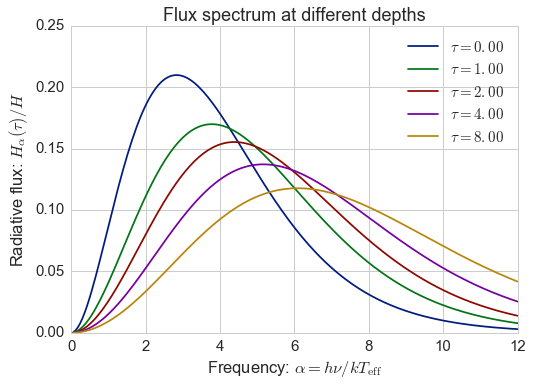

In [116]:
fig, ax = plt.subplots(1, 1)
Hlist = []
for tau in taus:
    H = flux(alpha_pts, tau)
    ax.plot(alpha_pts, H, label=r'$\tau = {:.2f}$'.format(tau))
    Hlist.append(H)
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(flux_label)
ax.set_title('Flux spectrum at different depths')
None

Now we do the same, but also show the normalized Planck function.  Make use of the previous flux calculations, which we saved in `Hlist`.  Only show every other `tau` value for clarity.

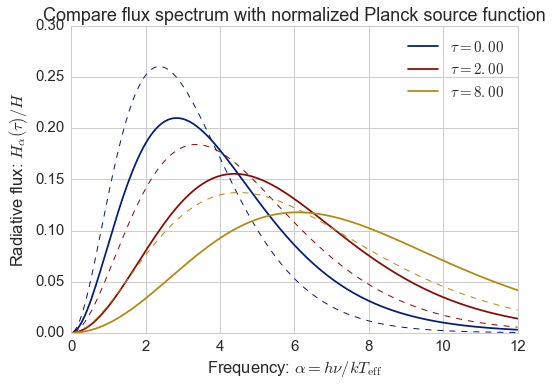

In [101]:
fig, ax = plt.subplots(1, 1)
colors = 'bry'
for tau, H, color in zip(taus[::2], Hlist[::2], colors):
    ax.plot(alpha_pts, H, c=color, 
            label=r'$\tau = {:.2f}$'.format(tau))
    B = p(tau)**4 * planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, lw=1, ls='--', c=color, label=None)
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(flux_label)
ax.set_title('Compare flux spectrum with normalized Planck source function')
None

The flux spectrum is always shifted to higher frequencies than the local source function.  This is increasingly true at larger depths.  This is because the flux depends on the gradient of the source function, $d B_\nu / d \tau$, rather than on $B_\nu$ itself.

## The mean intensity

This is not part of the homework, but the mean intensity can be done in a similar way.


In [106]:
def schwarz_integrand(t, alpha, tau):
    return 2.0*expn(1, abs(t - tau))*planck(alpha, t)    

def meanJ(alpha, tau):
    rslt = np.empty_like(alpha)
    for i, a in enumerate(alpha):
        rslt[i] = upward(a, tau, integrand=schwarz_integrand)
        if tau > 0.0:
            rslt[i] += downward(a, tau, integrand=schwarz_integrand)
    return rslt


### Plot the mean intensity

Unlike with the case of the flux, where the bolometric value is constant, the bolometric mean intensity increases with depth.

In [102]:
J_label = r'Mean intensity: $J_\alpha(\tau) / H$'

/Users/will/anaconda/lib/python3.4/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


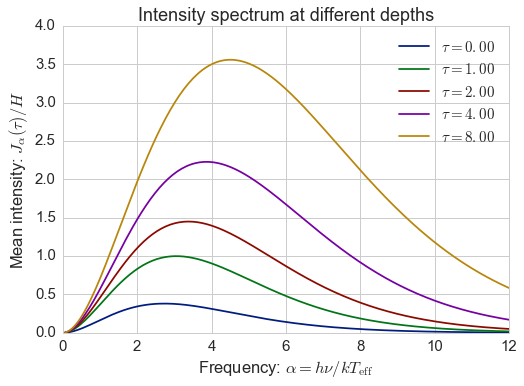

In [108]:
fig, ax = plt.subplots(1, 1)
Jlist = []
for tau in taus:
    J = meanJ(alpha_pts, tau)
    ax.plot(alpha_pts, J, label=r'$\tau = {:.2f}$'.format(tau))
    Jlist.append(J)
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(J_label)
ax.set_title('Intensity spectrum at different depths')
None

Next, we compare it with the Planck source function.  We multiply by 4 so that it is normalized by $H$ rather than $B(T_\mathrm{eff})$.  

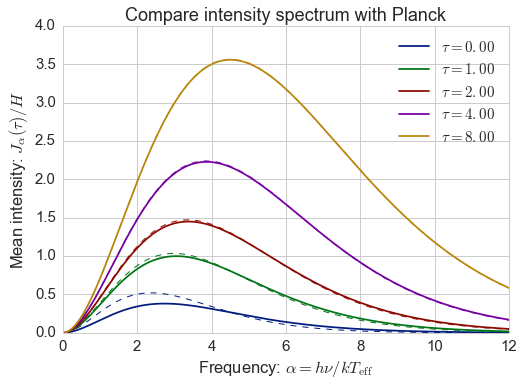

In [110]:
fig, ax = plt.subplots(1, 1)
colors = 'bgrmy'
for tau, J, color in zip(taus, Jlist, colors):
    ax.plot(alpha_pts, J, c=color, 
            label=r'$\tau = {:.2f}$'.format(tau))
    # B = p(tau)**4 * planck(alpha_pts, tau)
    B = 4*planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, lw=1, ls='--', c=color, label=None)
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(J_label)
ax.set_title('Compare intensity spectrum with Planck source function')
None

At the surface ($\tau = 0$) we have $J_\nu > B_\nu$ at high frequencies, but $J_\nu < B_\nu$ near the peak and at lower frequencies.  This is similar to the behavior of the flux at the surface. 

But at greater depths, the difference between $J_\nu$ and $B_\nu$ rapidly become very small, and are impossible to see on the graph for $\tau = 8$.

## Concentrate on $\tau = 0$

We normalize $J_\alpha$ and $B_\alpha$ by the surface value of the integrated Planck function $B(\tau\!=\!0) = \frac12 B(T_\mathrm{eff}) = 2 H$.

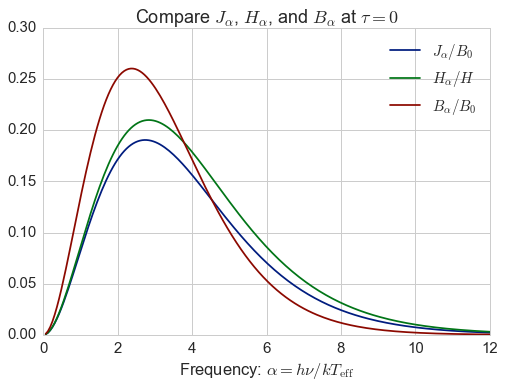

In [123]:
fig, ax = plt.subplots(1, 1)
J = Jlist[0]
H = Hlist[0]
B = 4*planck(alpha_pts, 0.0)
ax.plot(alpha_pts, J/2, label=r'$J_\alpha/B_0$')
ax.plot(alpha_pts, H, 
        label=r'$H_\alpha/H$')
ax.plot(alpha_pts, B/2, 
        label=r'$B_\alpha/B_0$')
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_title(r'Compare $J_\alpha$, $H_\alpha$, and $B_\alpha$ at $\tau = 0$')
None

## Tests

In [65]:
milne_integrand?

In [70]:
milne_integrand(t=np.linspace(0.0, 1.0, 11), alpha=1.0, tau=1.0)

array([ 0.02001928,  0.02466115,  0.03023914,  0.03700006,  0.04527319,
        0.0555142 ,  0.06838387,  0.08490683,  0.10685155,  0.13796286,
        0.19557701])